<img src=https://api-manager.universia.net/coreplatform-document-management/api/document-management/public/6ra7ymjkfi64845 width="300" align="left">
<br />

# Aprendizaje automático I
#### <font color=green>*Máster en Informática Industrial y Robótica*</font>

Daniel Vidal Soroa  
Juan Diego Peña 

## Clasificación de mangos en tres clases según su presencia para la exportación, comercio local o procesamiento industrial

#### Importación de las librerías:

In [18]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import shuffle
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix, classification_report, multilabel_confusion_matrix, recall_score,precision_score,f1_score,accuracy_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from random import seed
from random import randint
from tensorflow import keras
from keras import layers, models, utils, datasets
from keras import utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, GridSearchCV

In [2]:
%store -r scoring X X_train X_val CV t t_val f n h w
n1=X_val.shape
x_train = X
t_train = t
x_val = X_val.reshape(n1[0],h*w*3)

x_train, t_train = shuffle(x_train,t_train)
x_val,t_val = shuffle(x_val,t_val)


#### Validación cruzada con LR

In [7]:
modeLDA = LinearDiscriminantAnalysis()



### Analisis hiper-parametros LR 

In [9]:
param_grid = {
   'solver':['svd', 'lsqr']
   
}
search = GridSearchCV(estimator = modeLDA, param_grid =param_grid, n_jobs=-1,cv=CV,scoring=scoring,verbose=5,refit=False)

search_results = search.fit(x_train,t_train)



Fitting 5 folds for each of 2 candidates, totalling 10 fits


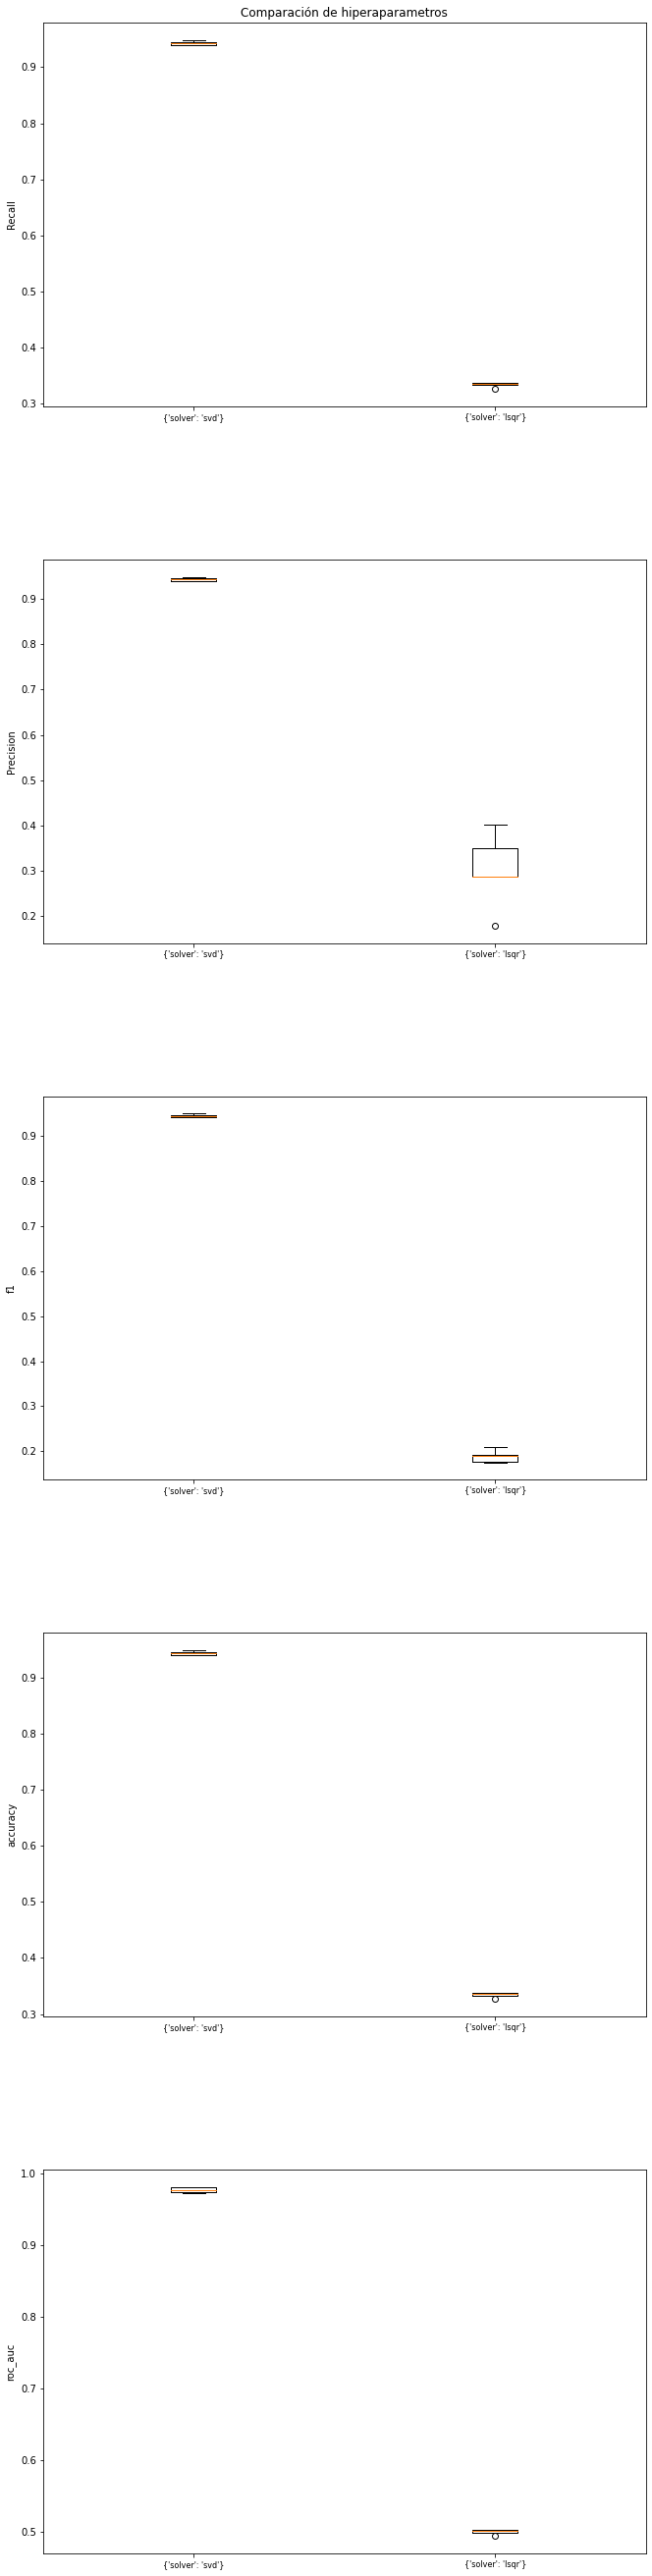

In [24]:
df = pd.DataFrame.from_dict(search_results.cv_results_)
df.to_excel("./informe/tables/parameters_lda.xlsx") 
labels = df['params']

data_recall =[]
data_precision = []
data_f1 =[]
data_accuracy = []
data_roc_auc  =[]


for c in range(len(labels)): 
    data_recall.append(df.iloc[c,7:12].to_list())  
    data_precision.append(df.iloc[c,15:20].to_list())  
    data_f1.append(df.iloc[c,23:28].to_list())  
    data_accuracy.append(df.iloc[c,31:36].to_list())  
    data_roc_auc.append(df.iloc[c,39:44].to_list())    


rotation = 0 

fig, ax = plt.subplots(5,1)

ax[0].boxplot(data_recall,labels=labels)
ax[0].set_xticklabels(labels=labels,rotation=rotation, fontsize=8)
ax[0].set(
    axisbelow=True,  # Hide the grid behind plot objects
    title='Comparación de hiperaparametros',
    ylabel='Recall'
    )

ax[1].boxplot(data_precision,labels=labels)
ax[1].set_xticklabels(labels=labels,rotation=rotation, fontsize=8)
ax[1].set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='Precision'
)

ax[2].boxplot(data_f1,labels=labels)
ax[2].set_xticklabels(labels=labels,rotation=rotation, fontsize=8)
ax[2].set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='f1'
)


ax[3].boxplot(data_accuracy,labels=labels)
ax[3].set_xticklabels(labels=labels,rotation=rotation, fontsize=8)
ax[3].set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='accuracy'
)


ax[4].boxplot(data_roc_auc,labels=labels)
ax[4].set_xticklabels(labels=labels,rotation=rotation, fontsize=8)
ax[4].set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='roc_auc'
)
fig.subplots_adjust(left=0.08, right=1.5, bottom=0.05, top=9,
                    hspace=0.4, wspace=0.3)

plt.show()


In [16]:
# Comparacion de hipotesis con accuracy
alpha = 0.05
F_statistic, pVal = stats.kruskal(data_accuracy[0],data_accuracy[1])

print ('p-valor KrusW:', pVal)

if pVal <= alpha:
    print('Rechazamos la hipótesis: los modelos son diferentes\n')
    stacked_data = np.vstack((data_accuracy[0],data_accuracy[1])).ravel()
    stacked_model = np.vstack((np.repeat('data_accuracy[0]',CV),np.repeat('data_accuracy[1]',CV))).ravel()    
    MultiComp = MultiComparison(stacked_data, stacked_model)
    comp = MultiComp.allpairtest(stats.ttest_rel, method='Holm')
    print (comp[0])    
    print(MultiComp.tukeyhsd(alpha=0.05))
else:
    print('Aceptamos la hipótesis: los modelos son iguales')

# Como los modelos son iguales aceptamos el modelo mas sencillo, osea el valor con el leaf mas alto

p-valor KrusW: 0.008815858177902036
Rechazamos la hipótesis: los modelos son diferentes

Test Multiple Comparison ttest_rel 
FWER=0.05 method=Holm
alphacSidak=0.05, alphacBonf=0.050
     group1           group2        stat   pval pval_corr reject
----------------------------------------------------------------
data_accuracy[0] data_accuracy[1] 375.7185  0.0       0.0   True
----------------------------------------------------------------
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1           group2      meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------------
data_accuracy[0] data_accuracy[1]  -0.6091   0.0 -0.6151 -0.6032   True
-----------------------------------------------------------------------


C:\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0, 0.5, 'Clase real')

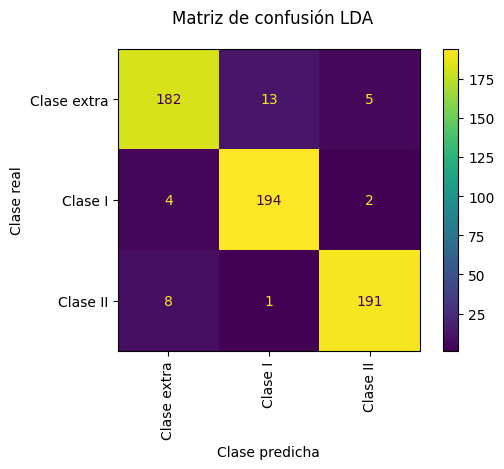

In [25]:
modeLDA = LinearDiscriminantAnalysis(solver='svd')
modeLDA.fit(x_train,t_train)
y_predict=modeLDA.predict(x_val)
Clases=['Clase extra','Clase I','Clase II']
disp = plot_confusion_matrix(modeLDA,x_val, t_val, display_labels = Clases, xticks_rotation = 'vertical') # Muestra gráficamente la matriz de confusión
disp.figure_.suptitle("Matriz de confusión LDA");                                                          # Añade un título a la figura de la matriz de confusión
disp.figure_.set_dpi(100)                                                                                  # Establece el tamaño de la figura
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")

In [22]:
mcm = multilabel_confusion_matrix(t_val, y_predict)
tn = mcm[:, 0, 0]
tp = mcm[:, 1, 1]
fn = mcm[:, 1, 0]
fp = mcm[:, 0, 1]

specificity_score = tn / (tn + fp)

print("recall: "+str(recall_score(t_val,y_predict,average='macro')))
print("precission:"+str(precision_score(t_val,y_predict,average='macro')))
print("f1:"+str(f1_score(t_val,y_predict,average='macro')))
print("accuracy:"+str(accuracy_score(t_val,y_predict)))    
print("roc_auc:"+str(roc_auc_score(t_val,modeLDA.predict_proba(x_val),multi_class='ovr')))
print("specificity: "+ str(np.mean(specificity_score)))

recall: 0.945
precission:0.9451610340785598
f1:0.9448790850506805
accuracy:0.945
roc_auc:0.9724749999999999
specificity: 0.9725


In [26]:
scoresLDA = cross_validate(modeLDA, x_train, t_train, cv=CV, scoring=scoring)
%store scoresLDA

Stored 'scoresLDA' (dict)
